Set parameter Username
Set parameter LicenseID to value 2667226
Academic license - for non-commercial use only - expires 2026-05-16
Set parameter TimeLimit to value 400
Set parameter MIPGap to value 0.01
Set parameter NumericFocus to value 3
Set parameter OutputFlag to value 1
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  400
MIPGap  0.01
MIPFocus  1
NumericFocus  3

Optimize a model with 61324 rows, 43806 columns and 76890848 nonzeros
Model fingerprint: 0xea0f22cd
Model has 8760 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-04, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 6e+06]
  Bounds range     [1e+03, 1e+03]
  RHS range        [2e+05, 5e+06]
Presolve removed 4 rows and 876

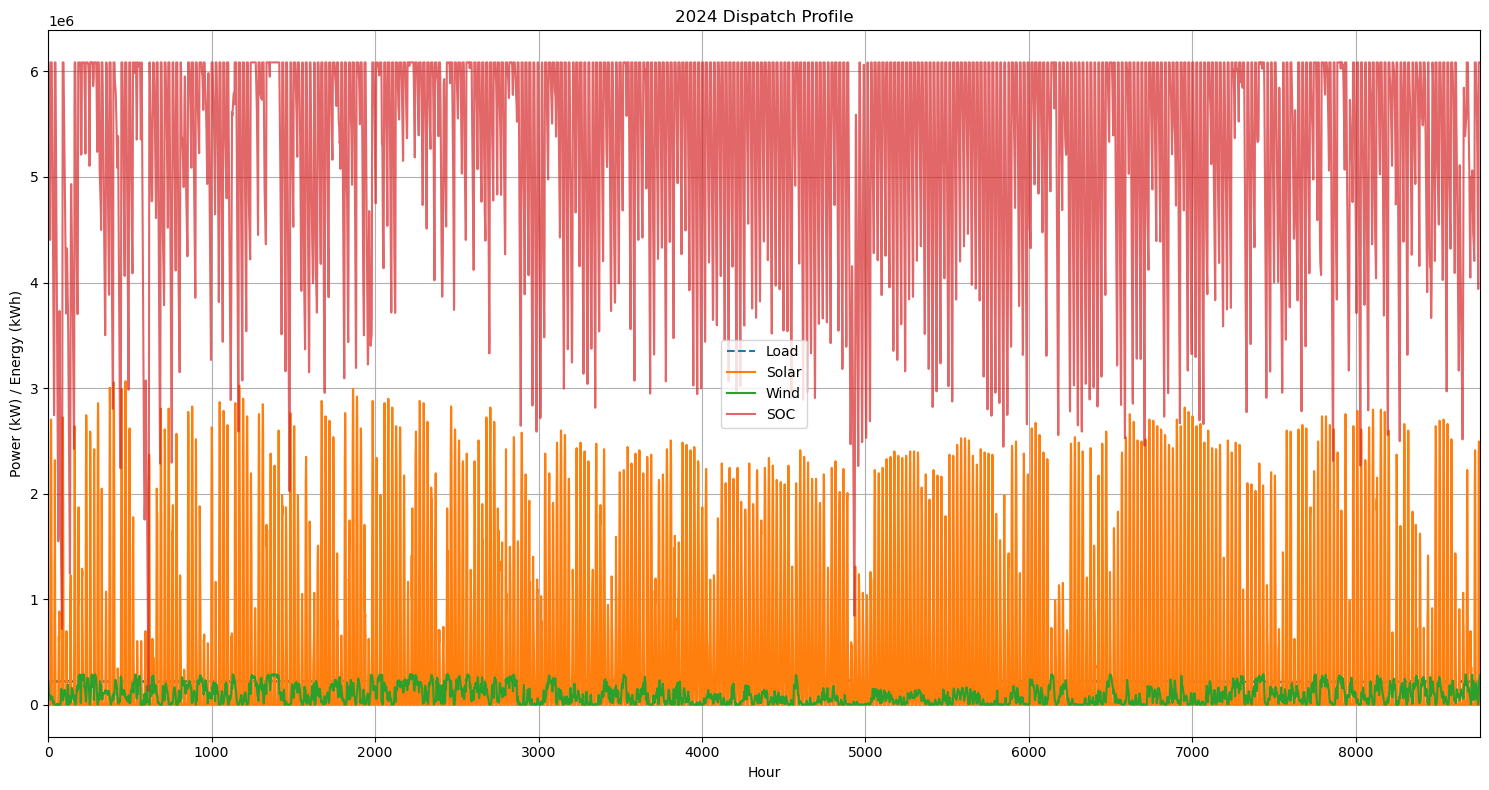

Saved dispatch data to dispatch_outputs_solar-wind_ac\dispatch_data_2024.csv
Saved hourly dispatch table to dispatch_outputs_solar-wind_ac\hourly_dispatch_2024.csv
Saved battery cycles to dispatch_outputs_solar-wind_ac\cycles_2024.csv
Saved dispatch plot to dispatch_outputs_solar-wind_ac\dispatch_profile_2024.png
Saved dispatch data to dispatch_outputs_solar-wind_ac\dispatch_data_2023.csv
Saved hourly dispatch table to dispatch_outputs_solar-wind_ac\hourly_dispatch_2023.csv
Saved battery cycles to dispatch_outputs_solar-wind_ac\cycles_2023.csv
Saved dispatch plot to dispatch_outputs_solar-wind_ac\dispatch_profile_2023.png
Saved dispatch data to dispatch_outputs_solar-wind_ac\dispatch_data_2022.csv
Saved hourly dispatch table to dispatch_outputs_solar-wind_ac\hourly_dispatch_2022.csv
Saved battery cycles to dispatch_outputs_solar-wind_ac\cycles_2022.csv
Saved dispatch plot to dispatch_outputs_solar-wind_ac\dispatch_profile_2022.png
Saved dispatch data to dispatch_outputs_solar-wind_ac\d

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import os

# === CONFIGURE ===
hours = 8760
base_power_csv = 'Desktop/base_power_profile.csv'
solar_csv_2024 = 'Desktop/Solar/2000s/ninja_pv_35.1460_-90.0518_uncorrected (0).csv'
wind_csv_2024 = 'Desktop/Wind/2000s/ninja_wind_35.1460_-90.0518_uncorrected (0).csv'
battery_efficiency = 0.89
dc_series_efficiency = 0.95 * 0.93
life_project = 15
output_dir = "dispatch_outputs_solar-wind_ac"  # Directory to save plots and CSVs

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# === Load and Preprocess 2024 Data ===
try:
    df_base = pd.read_csv(base_power_csv)
    base_power = df_base['Power_W'].to_numpy()
except FileNotFoundError:
    print("Error: base_power_profile.csv not found.")
    exit(1)

# PUE profile
quarter_midpoints = np.linspace(0, hours, 5)
pue_targets = [1.09, 1.11, 1.13, 1.08, 1.09]
hourly_pue = make_interp_spline(quarter_midpoints, pue_targets, k=3)(np.arange(hours))
dc_ac_conversion_efficiency = 0.975
load_profile = (base_power[:hours] / 1000) * 200000 * 1.405 * (hourly_pue / dc_ac_conversion_efficiency)

# 2024 Solar and wind resources
df_solar = pd.read_csv(solar_csv_2024, skiprows=3)
df_wind = pd.read_csv(wind_csv_2024, skiprows=3)
solar_vector = df_solar['electricity']
wind_vector = df_wind['electricity']
solar_resource_2024 = solar_vector[:hours]
wind_resource_2024 = wind_vector[:hours]

# === Optimization Parameters ===
inverter_capacity = (750 / 1000) * 200000 * 1.405 * (0.15 / dc_ac_conversion_efficiency)
cost_solar = 67.6 * 1.1 * 1.25
cost_wind = 5113800
cost_battery = 358
cost_inverter = 165 * 1.1 * 1.0795

om_solar = 7.965
om_wind = 93750
om_battery = 8.52
om_inverter = cost_inverter * 0.05

life_solar = 25
life_wind = 20
life_battery = 10
life_inverter = 10

unmet_load_penalty = 0
total_demand = sum(load_profile)
allowed_unmet = 0 * total_demand

inf = 0.023
dis = 0.045
timval = (1 + inf) / (1 + dis)

required_uptime = 0.99671
R_s = 0.99404
R_w = 0.99205
R_b = 0.99392
R_i = 0.997265

Ns_min = np.ceil(np.log(1 - required_uptime) / np.log(1 - R_s) * 1e5) / 1e5
Nw_min = np.ceil(np.log(1 - required_uptime) / np.log(1 - R_w) * 1e5) / 1e5
Nb_min = np.ceil(np.log(1 - required_uptime) / np.log(1 - R_b) * 1e5) / 1e5
Ni_min = np.ceil(np.log(1 - required_uptime) / np.log(1 - R_i) * 1e5) / 1e5

# === Optimization Function ===
def run_linear_milp_optimization_gurobipy(load_profile, solar_resource, wind_resource,
                                         cost_solar, cost_wind, cost_battery,
                                         unmet_load_penalty, battery_efficiency,
                                         Ns_min, Nw_min, Nb_min):
    try:
        model = gp.Model("EnergySystem")
        
        # Variables
        solar_capacity = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name="solar_capacity")
        wind_capacity = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name="wind_capacity")
        battery_capacity = model.addVar(lb=1000, vtype=GRB.CONTINUOUS, name="battery_capacity")
        battery_charge = model.addVars(hours, lb=0, vtype=GRB.CONTINUOUS, name="battery_charge")
        battery_discharge = model.addVars(hours, lb=0, vtype=GRB.CONTINUOUS, name="battery_discharge")
        battery_soc = model.addVars(hours, lb=0, vtype=GRB.CONTINUOUS, name="battery_soc")
        unmet_load = model.addVars(hours, lb=0, vtype=GRB.CONTINUOUS, name="unmet_load")
        curtailment = model.addVars(hours, lb=0, vtype=GRB.CONTINUOUS, name="curtailment")

        # NPC Calculations
        discount_factor = (1 - (timval)**life_project) / (1 - timval)
        solar_capex = cost_solar * solar_capacity * Ns_min
        wind_capex = cost_wind * wind_capacity * Nw_min
        battery_capex = cost_battery * battery_capacity * Nb_min
        inverter_capex = cost_inverter * inverter_capacity * Ni_min

        solar_opex = om_solar * solar_capacity * timval * discount_factor
        wind_opex = om_wind * wind_capacity * timval * discount_factor
        battery_opex = om_battery * battery_capacity * timval * discount_factor
        inverter_opex = om_inverter * inverter_capacity * timval * discount_factor

        solar_replacement = model.addVar(vtype=GRB.CONTINUOUS, name="solar_replacement")
        wind_replacement = model.addVar(vtype=GRB.CONTINUOUS, name="wind_replacement")
        inverter_replacement = model.addVar(vtype=GRB.CONTINUOUS, name="inverter_replacement")

        if life_solar >= life_project:
            model.addConstr(solar_replacement == 0)
        else:
            model.addConstr(solar_replacement == (solar_capex * (1 + inf)**life_solar) / ((1 + dis)**life_solar))

        if life_wind >= life_project:
            model.addConstr(wind_replacement == 0)
        else:
            model.addConstr(wind_replacement == (wind_capex * (1 + inf)**life_wind) / ((1 + dis)**life_wind))

        if life_inverter >= life_project:
            model.addConstr(inverter_replacement == 0)
        else:
            model.addConstr(inverter_replacement == (inverter_capex * (1 + inf)**life_inverter) / ((1 + dis)**life_inverter))

        solar_salvage = solar_capex * (life_solar - (life_project % life_solar)) / life_solar * ((1 + inf)**life_project) / ((1 + dis)**life_project)
        wind_salvage = wind_capex * (life_wind - (life_project % life_wind)) / life_wind * ((1 + inf)**life_project) / ((1 + dis)**life_project)
        battery_salvage = battery_capex * (life_battery - (life_project % life_battery)) / life_battery * ((1 + inf)**life_project) / ((1 + dis)**life_project)
        inverter_salvage = inverter_capex * (life_inverter - (life_project % life_inverter)) / life_inverter * ((1 + inf)**life_project) / ((1 + dis)**life_project)

        solar_npc = solar_capex + solar_replacement - solar_salvage + solar_opex
        wind_npc = wind_capex + wind_replacement - wind_salvage + wind_opex
        battery_npc = battery_capex - battery_salvage + battery_opex
        inverter_npc = inverter_capex + inverter_replacement - inverter_salvage + inverter_opex

        # Objective
        total_cost = (
            solar_npc +
            wind_npc +
            battery_npc +
            inverter_npc +
            unmet_load_penalty * gp.quicksum(unmet_load[t] for t in range(hours))
        )
        model.setObjective(total_cost, GRB.MINIMIZE)

        # Constraints
        model.addConstr(battery_soc[0] == battery_capacity, name="initial_soc")
        for t in range(hours):
            solar_gen = solar_resource[t] * solar_capacity * dc_series_efficiency
            wind_gen = wind_resource[t] * wind_capacity * dc_series_efficiency
            net_gen = solar_gen + wind_gen
            model.addConstr(battery_soc[t] <= battery_capacity, name=f"soc_upper_{t}")
            model.addConstr(battery_charge[t] <= battery_capacity, name=f"charge_upper_{t}")
            model.addConstr(battery_discharge[t] <= battery_capacity, name=f"discharge_upper_{t}")
            model.addConstr(battery_discharge[t] <= battery_soc[t], name=f"discharge_limit_{t}")
            model.addConstr(
                net_gen + battery_discharge[t] * dc_series_efficiency -
                battery_charge[t] / battery_efficiency - curtailment[t] -
                load_profile[t] + unmet_load[t] == 0,
                name=f"energy_balance_{t}"
            )
            model.addConstr(gp.quicksum(unmet_load[t] for t in range(hours)) <= allowed_unmet, name="unmet_load_limit")
            model.addConstr(battery_charge[t] * battery_discharge[t] <= 0, name=f"no_simul_charge_discharge_{t}")
            if t > 0:
                model.addConstr(
                    battery_soc[t] == battery_soc[t-1] +
                    battery_charge[t] -
                    battery_discharge[t] / battery_efficiency,
                    name=f"soc_update_{t}"
                )
        model.addConstr(battery_soc[hours-1] >= 0 * battery_capacity, name="min_final_soc")

        model.setParam("TimeLimit", 400)
        model.setParam("MIPGap", 0.01)
        model.setParam("NumericFocus", 3)
        model.setParam("OutputFlag", 1)
        model.setParam("MIPFocus", 1)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            print("Optimal Solution Found!")
            print(f"Solar Capacity: {solar_capacity.x:.2f} PV")
            print(f"Wind Capacity: {wind_capacity.x:.2f} HAWT")
            print(f"Battery Capacity: {battery_capacity.x:.2f} kWh")
            #print(f"Superficial NPC: ${model.objVal:.2f}")
            return {
                "solar": solar_capacity.x,
                "wind": wind_capacity.x,
                "battery": battery_capacity.x,
                "cost": model.objVal,
                "solar_capex": solar_capex.getValue(),
                "solar_opex": solar_opex.getValue(),
                "solar_replacement": solar_replacement.x,
                "solar_salvage": solar_salvage.getValue(),
                "wind_capex": wind_capex.getValue(),
                "wind_opex": wind_opex.getValue(),
                "wind_replacement": wind_replacement.x,
                "wind_salvage": wind_salvage.getValue(),
                "battery_capex": battery_capex.getValue(),
                "battery_opex": battery_opex.getValue(),
                "battery_salvage": battery_salvage.getValue(),
                "inverter_capex": inverter_capex,
                "inverter_opex": inverter_opex,
                "inverter_replacement": inverter_replacement.x,
                "inverter_salvage": inverter_salvage
            }
        else:
            print(f"Optimization Failed. Status: {model.status}")
            if model.status == GRB.INFEASIBLE:
                model.computeIIS()
                model.write("conflict.ilp")
                print("IIS written to conflict.ilp")
            return {"status": model.status}

    except gp.GurobiError as e:
        print(f"Gurobi Error: {e}")
        return {"status": "error"}
    except Exception as e:
        print(f"Error: {e}")
        return {"status": "error"}

# === Degradation Function ===
def calculate_rainflow_degradation_verbose(soc_series, capacity, A=0.000144, beta=1.79, dod_threshold=0.05):
    soc_series = np.array(soc_series)
    total_degradation = 0.0
    cycle_info = []
    peak = soc_series[0]
    valley = peak
    direction = None
    peak_hour = 0
    valley_hour = 0

    for i in range(1, len(soc_series)):
        if soc_series[i] > soc_series[i - 1]:
            if direction == 'down':
                dod = (peak - valley) / capacity if capacity > 0 else 0
                if dod >= dod_threshold:
                    degradation = A * (dod ** beta)
                    total_degradation += degradation
                    cycle_info.append({
                        "type": "discharge",
                        "peak_hour": peak_hour,
                        "valley_hour": valley_hour,
                        "DoD": round(dod, 4),
                        "degradation": round(degradation, 6)
                    })
                peak = soc_series[i]
                peak_hour = i
                direction = 'up'
            else:
                peak = max(peak, soc_series[i])
                if peak == soc_series[i]:
                    peak_hour = i
                direction = 'up'
        elif soc_series[i] < soc_series[i - 1]:
            if direction == 'up':
                valley = soc_series[i]
                valley_hour = i
                direction = 'down'
            else:
                valley = min(valley, soc_series[i])
                if valley == soc_series[i]:
                    valley_hour = i
                direction = 'down'

    return cycle_info, total_degradation

# === Function to Calculate Battery Replacement Cost ===
def calculate_battery_replacement_cost(battery_capex, degradation, inf, dis, life_battery):
    if degradation < 1:
        replacement_yearly = (battery_capex / (1 - degradation)) - battery_capex
        print(f"${replacement_yearly:.2f} is the replacement cost each year for degradation")
    else:
        replacement_yearly = 0

    battery_replacement_npc = 0
    for t in range(1, life_project + 1):
        battery_replacement_npc += replacement_yearly * ((1 + inf) ** t) / ((1 + dis) ** t)

    return battery_replacement_npc

# === Dispatch Simulation ===
def simulate_dispatch_fixed_capacities(load_profile, solar_resource, wind_resource,
                                      fixed_solar, fixed_wind, fixed_battery,
                                      battery_efficiency=0.89, initial_soc=0):
    hours = len(load_profile)
    model = gp.Model("fixed_dispatch")
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300

    battery_charge = model.addVars(hours, lb=0, name="charge")
    battery_discharge = model.addVars(hours, lb=0, name="discharge")
    battery_soc = model.addVars(hours, lb=0, ub=fixed_battery, name="soc")
    unmet_load = model.addVars(hours, lb=0, name="unmet")
    curtailment = model.addVars(hours, lb=0, name="curtailment")

    model.addConstr(battery_soc[0] == initial_soc)

    for t in range(hours):
        solar_gen = solar_resource[t] * fixed_solar * dc_series_efficiency
        wind_gen = wind_resource[t] * fixed_wind * dc_series_efficiency
        net_gen = solar_gen + wind_gen

        model.addConstr(battery_soc[t] <= fixed_battery)
        model.addConstr(battery_discharge[t] <= battery_soc[t])

        if t > 0:
            model.addConstr(
                battery_soc[t] == battery_soc[t - 1] +
                battery_charge[t] -
                battery_discharge[t] / battery_efficiency
            )

        model.addConstr(
            net_gen + battery_discharge[t] * dc_series_efficiency -
            battery_charge[t] / battery_efficiency - curtailment[t] -
            load_profile[t] + unmet_load[t] == 0
        )

    model.setObjective(gp.quicksum(unmet_load[t] for t in range(hours)), GRB.MINIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        battery_soc_vals = np.array([battery_soc[t].X for t in range(hours)])
        battery_charge_vals = np.array([battery_charge[t].X for t in range(hours)])
        battery_discharge_vals = np.array([battery_discharge[t].X for t in range(hours)])
        cycles, degradation = calculate_rainflow_degradation_verbose(battery_soc_vals, fixed_battery)

        return {
            "total_unmet": sum(unmet_load[t].X for t in range(hours)),
            "unmet_hours": [t for t in range(hours) if unmet_load[t].X > 1e-3],
            "unmet_profile": np.array([unmet_load[t].X for t in range(hours)]),
            "battery_soc": battery_soc_vals,
            "battery_charge": battery_charge_vals,
            "battery_discharge": battery_discharge_vals,
            "curtailment": np.array([curtailment[t].X for t in range(hours)]),
            "cycles": cycles,
            "degradation": degradation
        }
    else:
        return None

# === Function to Load Yearly Resources ===
def load_yearly_resources(year):
    try:
        if year >= 2000:
            idx = 2024 - year
            solar_csv = f'Desktop/Solar/2000s/ninja_pv_35.1460_-90.0518_uncorrected ({idx}).csv'
            wind_csv = f'Desktop/Wind/2000s/ninja_wind_35.1460_-90.0518_uncorrected ({idx}).csv'
        else:
            idx = year - 1900
            solar_csv = f'Desktop/Solar/1900s/ninja_pv_35.1460_-90.0518_uncorrected ({idx}).csv'
            wind_csv = f'Desktop/Wind/1900s/ninja_wind_35.1460_-90.0518_uncorrected ({idx}).csv'

        df_solar = pd.read_csv(solar_csv, skiprows=3)
        df_wind = pd.read_csv(wind_csv, skiprows=3)
        solar_vector = df_solar['electricity']
        wind_vector = df_wind['electricity']
        return solar_vector[:hours], wind_vector[:hours]
    except FileNotFoundError:
        print(f"Error: Resource files for year {year} not found.")
        return None, None

# === Function to Save Plot, CSVs, and Dispatch Text ===
def save_dispatch_output(year, dispatch_result, load_profile, solar_resource, wind_resource, fixed_solar, fixed_wind):
    df_dispatch = pd.DataFrame({
        "Hour": np.arange(hours),
        "Load (kW)": load_profile,
        "Solar (kW)": solar_resource * fixed_solar,
        "Wind (kW)": wind_resource * fixed_wind,
        "SOC (kWh)": dispatch_result["battery_soc"],
        "Charge (kW)": dispatch_result["battery_charge"],
        "Discharge (kW)": dispatch_result["battery_discharge"],
        "Unmet (kW)": dispatch_result["unmet_profile"],
        "Curtailment (kW)": dispatch_result["curtailment"]
    })

    # Save dispatch data CSV
    csv_path = os.path.join(output_dir, f"dispatch_data_{year}.csv")
    df_dispatch.to_csv(csv_path, index=False)
    print(f"Saved dispatch data to {csv_path}")

    # Save hourly dispatch table CSV
    dispatch_table_path = os.path.join(output_dir, f"hourly_dispatch_{year}.csv")
    df_dispatch.to_csv(dispatch_table_path, index=False)
    print(f"Saved hourly dispatch table to {dispatch_table_path}")

    # Save cycles CSV
    df_cycles = pd.DataFrame(dispatch_result["cycles"])
    cycles_path = os.path.join(output_dir, f"cycles_{year}.csv")
    df_cycles.to_csv(cycles_path, index=False)
    print(f"Saved battery cycles to {cycles_path}")

    # Save Plot
    plt.figure(figsize=(15, 8))
    plt.plot(df_dispatch["Hour"], df_dispatch["Load (kW)"], label="Load", linestyle='--')
    plt.plot(df_dispatch["Hour"], df_dispatch["Solar (kW)"], label="Solar")
    plt.plot(df_dispatch["Hour"], df_dispatch["Wind (kW)"], label="Wind")
    plt.plot(df_dispatch["Hour"], df_dispatch["SOC (kWh)"], label="SOC", alpha=0.7)
    #plt.plot(df_dispatch["Hour"], df_dispatch["Charge (kW)"], label="Charge", linestyle='-.')
    #plt.plot(df_dispatch["Hour"], df_dispatch["Discharge (kW)"], label="Discharge", linestyle='-.')
    #plt.plot(df_dispatch["Hour"], df_dispatch["Unmet (kW)"], label="Unmet", color="red", linewidth=2)
    #plt.plot(df_dispatch["Hour"], df_dispatch["Curtailment (kW)"], label="Curtailment", linestyle=':')
    plt.xlim(0, 8760)
    plt.legend()
    plt.grid(True)
    plt.title(f"Dispatch Profile for {year}")
    plt.xlabel("Hour")
    plt.ylabel("Power (kW) / Energy (kWh)")
    plt.tight_layout()
    plot_path = os.path.join(output_dir, f"dispatch_profile_{year}.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Saved dispatch plot to {plot_path}")

    return df_dispatch, df_cycles

# === Run Optimization for 2024 ===
opt_results = run_linear_milp_optimization_gurobipy(
    load_profile, solar_resource_2024, wind_resource_2024,
    cost_solar, cost_wind, cost_battery,
    unmet_load_penalty, battery_efficiency,
    Ns_min, Nw_min, Nb_min
)

# === Process Results ===
if isinstance(opt_results, dict) and "status" not in opt_results:
    # Run dispatch simulation for 2024 (full output)
    dispatch_result = simulate_dispatch_fixed_capacities(
        load_profile=load_profile,
        solar_resource=solar_resource_2024,
        wind_resource=wind_resource_2024,
        fixed_solar=opt_results["solar"],
        fixed_wind=opt_results["wind"],
        fixed_battery=opt_results["battery"],
        initial_soc=opt_results["battery"]
    )

    if dispatch_result:

        # Calculate curtailment, generation, and percentage
        total_curtailed = np.sum(dispatch_result["curtailment"])
        solar_gen = solar_resource_2024 * opt_results["solar"] 
        wind_gen = wind_resource_2024 * opt_results["wind"] 
        total_generated = np.sum(solar_gen + wind_gen)
        total_power_consumed = total_generated-total_curtailed
        utilization_percentage = (total_power_consumed / total_generated * 100) if total_generated > 0 else 0
        

        # Print results
        print("\n=== 2024 Curtailment and Generation Metrics ===")
        print(f"Total Energy Curtailed: {total_curtailed:.2f} kWh")
        print(f"Total Energy Generated: {total_generated:.2f} kWh")
        print(f"Total Energy Used (along with efficiency losses): {total_power_consumed:.2f} kWh")
        print(f"Utilization Percentage: {utilization_percentage:.2f}%")
        
        # Calculate redundant capacities and costs
        solar_initial_capacity = opt_results["solar"]
        wind_initial_capacity = opt_results["wind"]
        battery_initial_capacity = opt_results["battery"]
        inverter_initial_capacity = inverter_capacity

        solar_initial_cost = cost_solar * solar_initial_capacity
        wind_initial_cost = cost_wind * wind_initial_capacity
        battery_initial_cost = cost_battery * battery_initial_capacity
        inverter_initial_cost = cost_inverter * inverter_initial_capacity

        solar_redundant_capacity = (Ns_min - 1) * opt_results["solar"]
        wind_redundant_capacity = (Nw_min - 1) * opt_results["wind"]
        battery_redundant_capacity = (Nb_min - 1) * opt_results["battery"]
        inverter_redundant_capacity = inverter_capacity * (Ni_min-1)

        solar_redundant_cost = cost_solar * solar_redundant_capacity
        wind_redundant_cost = cost_wind * wind_redundant_capacity
        battery_redundant_cost = cost_battery * battery_redundant_capacity
        inverter_redundant_cost = cost_inverter * inverter_redundant_capacity
        

        # Calculate battery replacement cost
        yearly_degradation = dispatch_result["degradation"]
        battery_replacement = calculate_battery_replacement_cost(
            battery_capex=opt_results["battery_capex"],
            degradation=yearly_degradation,
            inf=inf,
            dis=dis,
            life_battery=life_battery
        )

        # Update total NPC
        total_npc = opt_results["cost"] + battery_replacement

        # Display initial capacities and costs
        print("\nRedundant Capacities and Costs:")
        print(f"Solar Initial Capacity: {solar_initial_capacity:.2f} PV")
        print(f"Solar Initial Cost:    ${solar_initial_cost:.2f}")
        print(f"Wind Initial Capacity: {wind_initial_capacity:.2f} HAWT")
        print(f"Wind Initial Cost:     ${wind_initial_cost:.2f}")
        print(f"Battery Initial Capacity: {battery_initial_capacity:.2f} kWh")
        print(f"Battery Initial Cost:  ${battery_initial_cost:.2f}")
        print(f"Inverter Initial Capacity: {inverter_initial_capacity:.2f} kW")
        print(f"Inverter Initial Cost:  ${inverter_initial_cost:.2f}")

        # Display redundant capacities and costs
        print("\nRedundant Capacities and Costs:")
        print(f"Solar Redundant Capacity: {solar_redundant_capacity:.2f} PV")
        print(f"Solar Redundant Cost:    ${solar_redundant_cost:.2f}")
        print(f"Wind Redundant Capacity: {wind_redundant_capacity:.2f} HAWT")
        print(f"Wind Redundant Cost:     ${wind_redundant_cost:.2f}")
        print(f"Battery Redundant Capacity: {battery_redundant_capacity:.2f} kWh")
        print(f"Battery Redundant Cost:  ${battery_redundant_cost:.2f}")
        print(f"Inverter Redundant Capacity: {inverter_redundant_capacity:.2f} kW")
        print(f"Inverter Redundant Cost:  ${inverter_redundant_cost:.2f}")

        # Display cost breakdown
        print("\nCost Breakdown:")
        print(f"Solar CAPEX:        ${opt_results['solar_capex']:.2f}")
        print(f"Solar OPEX:         ${opt_results['solar_opex']:.2f}")
        print(f"Solar Replacement:  ${opt_results['solar_replacement']:.2f}")
        print(f"Solar Salvage:     -${opt_results['solar_salvage']:.2f}")
        print(f"Wind CAPEX:         ${opt_results['wind_capex']:.2f}")
        print(f"Wind OPEX:          ${opt_results['wind_opex']:.2f}")
        print(f"Wind Replacement:   ${opt_results['wind_replacement']:.2f}")
        print(f"Wind Salvage:      -${opt_results['wind_salvage']:.2f}")
        print(f"Battery CAPEX:      ${opt_results['battery_capex']:.2f}")
        print(f"Battery OPEX:       ${opt_results['battery_opex']:.2f}")
        print(f"Battery Replacement:${battery_replacement:.2f}")
        print(f"Battery Salvage:   -${opt_results['battery_salvage']:.2f}")
        print(f"Inverter CAPEX:     ${opt_results['inverter_capex']:.2f}")
        print(f"Inverter OPEX:      ${opt_results['inverter_opex']:.2f}")
        print(f"Inverter Replacement:${opt_results['inverter_replacement']:.2f}")
        print(f"Inverter Salvage:   -${opt_results['inverter_salvage']:.2f}")
        print(f"Total NPC:          ${total_npc:.2f}")

        print("\n=== 2024 Results ===")
        print(f"Total Unmet Load: {dispatch_result['total_unmet']:.2f} kWh")
        print(f"Hours with Unmet Load: {dispatch_result['unmet_hours']}")
        print("\nDetected Battery Cycles:")
        df_cycles = pd.DataFrame(dispatch_result["cycles"])
        print(df_cycles.to_string(index=False))
        print(f"\nTotal Estimated Degradation: {dispatch_result['degradation']:.6f}")

        df_dispatch, df_cycles = save_dispatch_output(
            year=2024,
            dispatch_result=dispatch_result,
            load_profile=load_profile,
            solar_resource=solar_resource_2024,
            wind_resource=wind_resource_2024,
            fixed_solar=opt_results["solar"],
            fixed_wind=opt_results["wind"]
        )

       # with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.6f}'.format):
       #     for _, row in df_dispatch.iterrows():
       #         print(f"Hour {int(row['Hour'])}: Load={row['Load (kW)']:.2f} | Solar={row['Solar (kW)']:.2f} | "
       #               f"Wind={row['Wind (kW)']:.2f} | Charge={row['Charge (kW)']:.2f} | Discharge={row['Discharge (kW)']:.2f} | "
       #               f"SOC={row['SOC (kWh)']:.2f} | Unmet={row['Unmet (kW)']:.2f} | Curtailment={row['Curtailment (kW)']:.2f}")

        # Display plot for 2024
        plt.figure(figsize=(15, 8))
        plt.plot(df_dispatch["Hour"], df_dispatch["Load (kW)"], label="Load", linestyle='--')
        plt.plot(df_dispatch["Hour"], df_dispatch["Solar (kW)"], label="Solar")
        plt.plot(df_dispatch["Hour"], df_dispatch["Wind (kW)"], label="Wind")
        plt.plot(df_dispatch["Hour"], df_dispatch["SOC (kWh)"], label="SOC", alpha=0.7)
       # plt.plot(df_dispatch["Hour"], df_dispatch["Charge (kW)"], label="Charge", linestyle='-.')
        #plt.plot(df_dispatch["Hour"], df_dispatch["Discharge (kW)"], label="Discharge", linestyle='-.')
        #plt.plot(df_dispatch["Hour"], df_dispatch["Unmet (kW)"], label="Unmet", color="red", linewidth=2)
        #plt.plot(df_dispatch["Hour"], df_dispatch["Curtailment (kW)"], label="Curtailment", linestyle=':')
        plt.xlim(0, 8760)
        plt.legend()
        plt.grid(True)
        plt.title("2024 Dispatch Profile")
        plt.xlabel("Hour")
        plt.ylabel("Power (kW) / Energy (kWh)")
        plt.tight_layout()
        plt.show()

        # === Evaluate Unmet Load for All Years ===
        unmet_loads = {}
        for year in range(2024, 1979, -1):
            solar_resource, wind_resource = load_yearly_resources(year)
            if solar_resource is None or wind_resource is None:
                unmet_loads[year] = None
                continue

            dispatch_result = simulate_dispatch_fixed_capacities(
                load_profile=load_profile,
                solar_resource=solar_resource,
                wind_resource=wind_resource,
                fixed_solar=opt_results["solar"],
                fixed_wind=opt_results["wind"],
                fixed_battery=opt_results["battery"],
                initial_soc=opt_results["battery"]
            )

            if dispatch_result:
                unmet_loads[year] = dispatch_result["total_unmet"]
                save_dispatch_output(
                    year=year,
                    dispatch_result=dispatch_result,
                    load_profile=load_profile,
                    solar_resource=solar_resource,
                    wind_resource=wind_resource,
                    fixed_solar=opt_results["solar"],
                    fixed_wind=opt_results["wind"]
                )
            else:
                unmet_loads[year] = None

        # === Display Unmet Load Results ===
        print("\n=== Unmet Load Across Years ===")
        valid_unmet_loads = []
        for year in range(2024, 1979, -1):
            if unmet_loads[year] is not None:
                print(f"Year {year}: Unmet Load = {unmet_loads[year]:.2f} kWh")
                valid_unmet_loads.append(unmet_loads[year])
            else:
                print(f"Year {year}: Unmet Load = Failed (missing data or optimization error)")

        if valid_unmet_loads:
            avg_unmet = np.mean(valid_unmet_loads)
            print(f"\nAverage Unmet Load (1979-2024): {avg_unmet:.2f} kWh")
            print(f"Min Unmet Load: {min(valid_unmet_loads):.2f} kWh (Year {min((year for year, val in unmet_loads.items() if val == min(valid_unmet_loads)), default='N/A')})")
            print(f"Max Unmet Load: {max(valid_unmet_loads):.2f} kWh (Year {max((year for year, val in unmet_loads.items() if val == max(valid_unmet_loads)), default='N/A')})")
        else:
            print("\nNo valid unmet load data available.")

    else:
        print("Dispatch simulation for 2024 failed.")
else:
    print("Optimization for 2024 failed.")